# COMP5046 Assignment2

# 1 - Data Preprocessing

## 1.1Read Data

In [24]:
import pandas as pd
import datetime
from sklearn.metrics import f1_score
def read_data(file_name):
    df = pd.read_csv(file_name)
    Sentences = ' '.join(df.Sentence.tolist()).split(' . ')
    word = ' '.join(df.Sentence.tolist()).split(' ')
    try:
        target = ' '.join(df.NER.tolist()).split(' ')

    except:
        target = df.NER.tolist()
    train = [sentence.strip().split() + ['.'] for sentence in Sentences]
    train[-1] = train[-1][:-1]
    i = 0
    tags = []
    for sentence in train:
        tag = target[i:i + len(sentence)]
        tags.append(tag)
        i += len(sentence)
    print("data has been loaded!")
    return train, tags


def read_test_data(file_name):
    df = pd.read_csv(file_name)
    Sentences = ' '.join(df.Sentence.tolist()).split(' . ')
    word = ' '.join(df.Sentence.tolist()).split(' ')
    train = [sentence.strip().split() + ['.'] for sentence in Sentences]
    train[-1] = train[-1][:-1]
    print("test data has been loaded!")
    return train


train_data, target_y_train = read_data("train.csv")
validation_data, target_y_validation = read_data("val.csv")
test_data = read_test_data('test.csv')

data has been loaded!
data has been loaded!
test data has been loaded!


## 1.2 Build Features

### 1.2.1 TF-IDF Score

In [25]:
def tf_idf(data):
    import numpy as np
    DF = {}

    for tokensized_doc in data:
        # get each unique word in the doc - we need to know whether the word is appeared in the document
        for term in np.unique(tokensized_doc):
            try:
                DF[term] += 1
            except:
                DF[term] = 1

    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from collections import Counter
    import math

    tf_idf = {}

    # total number of documents
    N = len(data)

    doc_id = 0
    # get each tokenised doc
    for tokensized_doc in data:
        # initialise counter for the doc
        counter = Counter(tokensized_doc)
        # calculate total number of words in the doc
        total_num_words = len(tokensized_doc)

        # get each unique word in the doc
        for term in np.unique(tokensized_doc):
            # calculate Term Frequency
            tf = counter[term] / total_num_words

            # calculate Document Frequency
            df = DF[term]

            # calculate Inverse Document Frequency
            idf = math.log(N / (df + 1)) + 1

            # calculate TF-IDF
            tf_idf[doc_id, term] = tf * idf

        doc_id += 1

    TF_doc=[]
    for i in range(N):
        temp=[]
        for word in data[i]:
            temp.append(tf_idf[(i,word)])
        TF_doc.append(temp)

    return TF_doc

### 1.2.2 POS Tag

In [ ]:
import nltk
import pandas as pd

nltk.download('punkt')
from nltk import word_tokenize

nltk.download('treebank')
from nltk.corpus import treebank

import numpy as np
from sklearn.model_selection import train_test_split

# Retrieve tagged sentences from treebank corpus
tagged_sentences = nltk.corpus.treebank.tagged_sents()

print(tagged_sentences[0])
print("Tagged sentences: ", len(tagged_sentences))
print("Tagged words:", len(nltk.corpus.treebank.tagged_words()))
# tagged_words(): list of (str,str) tuple

sentences, sentence_tags = [], []
for tagged_sentence in tagged_sentences:
    # The zip() function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together,
    # and then the second item in each passed iterator are paired together etc.
    sentence, tags = zip(*tagged_sentence)
    sentence = [word.lower() for word in sentence]
    sentences.append(np.array(sentence))
    sentence_tags.append(np.array(tags))

print(sentences[5])
print(sentence_tags[5])

(train_sentences,
 test_sentences,
 train_tags,
 test_tags) = train_test_split(sentences, sentence_tags, test_size=0.2)

words, tags = set([]), set([])

for s in train_sentences:
    for w in s:
        words.add(w.lower())

for ts in train_tags:
    for t in ts:
        tags.add(t)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs

tag2index = {t: i + 2 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  # The special value used to padding
tag2index['-OOV-'] = 1  # The special value used for OOVs


def tag_to_index(tag):
    if tag in tag2index:
        return tag2index[tag]
    else:
        return tag2index['-OOV-']

train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []

for s in train_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])

    train_sentences_X.append(s_int)

for s in test_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])

    test_sentences_X.append(s_int)

for s in train_tags:
    train_tags_y.append([tag_to_index(t) for t in s])

for s in test_tags:
    test_tags_y.append([tag_to_index(t) for t in s])

print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

MAX_LENGTH = len(max(train_sentences_X, key=len))
print(MAX_LENGTH)

import torch
new_train_sentences_X = [torch.from_numpy(np.array(l)) for l in train_sentences_X]
new_test_sentences_X = [torch.from_numpy(np.array(l)) for l in test_sentences_X]
new_train_tags_y = [torch.from_numpy(np.array(l)) for l in train_tags_y]
new_test_tags_y = [torch.from_numpy(np.array(l)) for l in test_tags_y]

from torch.nn.utils.rnn import pad_sequence
after_pad = pad_sequence(new_train_sentences_X+new_test_sentences_X+new_train_tags_y+new_test_tags_y,batch_first=True)
train_sentences_X_pad = after_pad[:len(new_train_sentences_X)]
test_sentences_X_pad = after_pad[len(new_train_sentences_X):len(new_train_sentences_X)+len(new_test_sentences_X)]
train_tags_y_pad = after_pad[len(new_train_sentences_X)+len(new_test_sentences_X):-len(new_test_tags_y)]
test_tags_y_pad = after_pad[-len(new_test_tags_y):]

#More detailed info about the TensorDataset, https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataset.html#TensorDataset
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_X_pad, train_tags_y_pad)

batch_size = 128
#More detailed info about the dataLoader, https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataloader.html
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,batch_first=True, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)


    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=-1)
        return tag_scores


EMBEDDING_DIM = 128
HIDDEN_DIM = 256

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2index), len(tag2index)).cuda()
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(40):
    loss_now = 0.0
    acc = 0

    for sentence,targets in train_loader:
        sentence = sentence.cuda()
        targets = targets.cuda()

        model.zero_grad()
        model.train()
        tag_scores = model(sentence)

        # loss = loss_function(tag_scores, targets)
        loss = loss_function(tag_scores.view(-1,tag_scores.size(-1)), targets.view(-1))
        loss.backward()
        optimizer.step()

        loss_now+=loss.item()

        model.eval()
        tag_scores = model(sentence)
        _, predicted = torch.max(tag_scores, -1)
        prediction = predicted.view(-1).cpu().numpy()
        t = targets.view(-1).cpu().numpy()
        # Note: The training accuracy here is calculated with "PAD", which means most of pos tag will be "0".
        acc = acc+accuracy_score(prediction,t)*len(prediction)
    print('Epoch: %d, training loss: %.4f, training acc: %.2f%%'%(epoch+1,loss_now,100*acc/len(train_sentences_X)/MAX_LENGTH))

model.eval()
sentence = test_sentences_X_pad.cuda()
tag_scores = model(sentence)
_, predicted = torch.max(tag_scores, -1)
predicted = predicted.cpu().numpy()

# cut off the PAD part
test_len_list = [len(s) for s in test_sentences_X]
actual_predicted_list= []
for i in range(predicted.shape[0]):
    actual_predicted_list+=list(predicted[i])[:test_len_list[i]]

# get actual tag list
actual_tags = sum(test_tags_y, [])

print('Test Accuracy: %.2f%%'%(accuracy_score(actual_predicted_list,actual_tags)*100))

def read_data(file_name):
    df = pd.read_csv(file_name)
    Sentences = ' '.join(df.Sentence.tolist()).split(' . ')
    word = ' '.join(df.Sentence.tolist()).split(' ')
    try:
        target = ' '.join(df.NER.tolist()).split(' ')

    except:
        target = df.NER.tolist()
    train = [sentence.strip().split() + ['.'] for sentence in Sentences]
    train[-1] = train[-1][:-1]
    i = 0
    tags = []
    for sentence in train:
        tag = target[i:i + len(sentence)]
        tags.append(tag)
        i += len(sentence)
    print("data has been loaded!")
    return train, tags


def read_test_data(file_name):
    df = pd.read_csv(file_name)
    Sentences = ' '.join(df.Sentence.tolist()).split(' . ')
    word = ' '.join(df.Sentence.tolist()).split(' ')
    train = [sentence.strip().split() + ['.'] for sentence in Sentences]
    train[-1] = train[-1][:-1]
    print("test data has been loaded!")
    return train


train_data, target_y_train = read_data("train.csv")
validation_data, target_y_validation = read_data("val.csv")
test_data = read_test_data('test.csv')

pre_data = train_data+validation_data+test_data

#decode the result to have actual tags
def decode_result(predictions, test_samples_X, index2tag):
    token_sequences = []
    ## write your codes here
    # cut off the PAD part
    test_len_list = [len(s) for s in test_samples_X]
    actual_predicted_list= []
    for i in range(predictions.shape[0]):
        actual_predicted_tagindex = list(predictions[i])[:test_len_list[i]]
        actual_predicted_tag = [index2tag[index] for index in actual_predicted_tagindex]
        token_sequences.append(actual_predicted_tag)

    return token_sequences

batch = 100
batch_num = len(pre_data)//batch+1
predict = []
for i in range(batch_num):
    test_samples = pre_data[i*batch:min((i+1)*batch,len(pre_data))]
    MAX_LENGTH = len(max(pre_data, key=len))
    print(test_samples)
    # Converting sentence (tokens) word to index
    test_samples_X = []
    for s in test_samples:
        s_int = []
        for w in s:
            try:
                s_int.append(word2index[w.lower()])
            except KeyError:
                s_int.append(word2index['-OOV-'])
                test_samples_X.append(s_int)

    # manually add PAD
    test_samples_X_pad = []
    for l in test_samples_X:
        test_samples_X_pad.append(l+[0]*(MAX_LENGTH-len(l)))

    index2tag = {i: t for t, i in tag2index.items()}

    model.eval()
    sentence = torch.from_numpy(np.array(test_samples_X_pad)).cuda()
    predictions = model(sentence)
    _, predictions = torch.max(predictions, -1)
    predictions = predictions.cpu().numpy()
    POS = decode_result(predictions, test_samples_X, index2tag )
    predict = predict + POS

POS_tag = [' '.join(predict[i]) for i in range(len(predict))]
tag = pd.DataFrame(POS_tag)
tag.to_csv('POS_tag_sentence.csv')

In [ ]:
df = pd.read_csv("POS_tag_sentence.csv")
POS = df['0'].tolist()
POS_tag = [tag.split() for tag in POS]

## 1.3 Build Feature to Data

### 1.3.1 Build Word and Tag Dictionary

In [26]:
word_to_ix = {}
for sentence in train_data+validation_data+test_data:
    for word in sentence:
        word = word.lower()
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_list = list(word_to_ix.keys())

START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix = {START_TAG:0, STOP_TAG:1}
for tags in target_y_train+target_y_validation:
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

pos_to_ix = {START_TAG:0, STOP_TAG:1}
for tags in POS_tag:
    for tag in tags:
        if tag not in pos_to_ix:
            pos_to_ix[tag] = len(pos_to_ix)

### 1.3.2 Load Pretrained Model

In [27]:
import gensim.downloader as api
import numpy as np
word_emb_model = api.load("glove-twitter-50")
print("="*89)
print("pre-trained word embedding model has been loaded!")
print("="*89)
EMBEDDING_DIM = 50

embedding_matrix = []
for word in word_list:
    try:
        embedding_matrix.append(word_emb_model.wv[word])
    except:
        embedding_matrix.append([0]*EMBEDDING_DIM)
embedding_matrix = np.array(embedding_matrix)
embedding_matrix.shape

pre-trained word embedding model has been loaded!


/Users/dereklucifer/opt/anaconda3/envs/NLP_lab/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


(13972, 50)

### 1.3.3 Transform Data to Index

In [28]:
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] for w in sent])
    return input_index_list

In [29]:
train_pos = POS_tag[:len(train_data)]
val_pos = POS_tag[len(train_data):(len(train_data+validation_data))]
test_pos = POS_tag[-len(test_data):]

train_input_index =  to_index(train_data,word_to_ix)
train_pos_index =  to_index(train_pos,pos_to_ix)
train_output_index = to_index(target_y_train,tag_to_ix)
val_input_index = to_index(validation_data,word_to_ix)
val_pos_index =  to_index(val_pos,pos_to_ix)
val_output_index = to_index(target_y_validation,tag_to_ix)
test_input_index = to_index(test_data,word_to_ix)
test_pos_index =  to_index(test_pos,pos_to_ix)

train_tf_idf_index = tf_idf(train_data)
val_tf_idf_index = tf_idf(validation_data)
test_tf_idf_index = tf_idf(test_data)

# 2 - Model Implementation

## 2.0 Baseline Model

In [121]:
# Author: Robert Guthrie

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

#### Function for accuracy [Please Complete this part]

#Please complete the cal_acc function that generates the model predictions using the input data and calculates the accuracy by comparing the model predictions with the ground truth labels. You can refer to the [Train the model] section regarding what the inputs and outputs are and how it will be used.

import numpy as np
from sklearn.metrics import accuracy_score
def cal_acc(model, input_index,output_index):
    import sklearn
    ground_truth = []
    predicted = []
    for i in range(len(input_index)):
        input_sent = input_index[i]
        output_tag = output_index[i]
        input_sent = torch.tensor(input_sent, dtype=torch.long).to(device)
        _,prediction = model(input_sent)
        predicted = predicted + prediction
        ground_truth = ground_truth + output_tag
    accuracy = float((np.array(predicted)==np.array(ground_truth)).astype(int).sum())/float(len(ground_truth))
    f1_ = sklearn.metrics.f1_score(np.array(ground_truth).tolist(), np.array(predicted).tolist(),average='micro')
    return ground_truth, predicted, accuracy,f1_

#### Initialize Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 128


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix,EMBEDDING_DIM, HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

#### Train the model

"""Each epoch will take about 1-2 minutes"""

import datetime
base_f1 = []
for epoch in range(10):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        pos_index = train_pos_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    _, _, train_acc,_ = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc,b_f1 = cal_acc(model,val_input_index,val_output_index)
    base_f1.append(b_f1)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


### Testing



Epoch:1, Training loss: 22134.89, train acc: 0.8433, val loss: 3895.08, val acc: 0.8163, time: 121.31s
Epoch:2, Training loss: 14382.07, train acc: 0.8761, val loss: 3245.10, val acc: 0.8524, time: 124.93s
Epoch:3, Training loss: 10559.34, train acc: 0.9086, val loss: 2831.67, val acc: 0.8703, time: 123.74s
Epoch:4, Training loss: 7848.18, train acc: 0.9318, val loss: 2676.97, val acc: 0.8778, time: 125.44s
Epoch:5, Training loss: 5825.45, train acc: 0.9520, val loss: 2589.47, val acc: 0.8841, time: 121.97s
Epoch:6, Training loss: 4227.77, train acc: 0.9683, val loss: 2584.07, val acc: 0.8923, time: 131.11s
Epoch:7, Training loss: 2965.59, train acc: 0.9798, val loss: 2614.15, val acc: 0.8948, time: 133.51s
Epoch:8, Training loss: 1999.76, train acc: 0.9860, val loss: 2796.17, val acc: 0.8944, time: 130.64s
Epoch:9, Training loss: 1324.91, train acc: 0.9934, val loss: 2784.44, val acc: 0.8972, time: 124.91s
Epoch:10, Training loss: 920.95, train acc: 0.9954, val loss: 2905.71, val acc:

In [125]:
y_true,y_pred,_,_ = cal_acc(model,val_input_index,val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

from sklearn.metrics import classification_report
import sklearn
print(classification_report(y_true_decode,y_pred_decode,digits=4))
baseline_f1_ = sklearn.metrics.f1_score(np.array(y_true), np.array(y_pred),average='micro')
print(baseline_f1_)

              precision    recall  f1-score   support

       I-LOC     0.7977    0.8186    0.8080       419
      I-MISC     0.6103    0.6364    0.6230       187
       I-ORG     0.5115    0.3895    0.4422       285
       I-PER     0.8596    0.6857    0.7629       875
           O     0.9302    0.9665    0.9480      5790

    accuracy                         0.8958      7556
   macro avg     0.7418    0.6993    0.7168      7556
weighted avg     0.8910    0.8958    0.8917      7556

0.8958443620963473


## 2.1 Build NER Model

In [115]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.manual_seed(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
           torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))


import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)


def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
           torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))


class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, lstm_dim=90, embedding_dim=50, hidden_dim=128,linear = 256, num_layers=2,
                 method='ATTN_TYPE_DOT_PRODUCT'):
        super(BiLSTM_CRF, self).__init__()
        self.method = method
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.pos_to_ix = pos_to_ix
        self.posset_size = len(pos_to_ix)
        self.lstm_dim = lstm_dim
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.linear = linear

        """Here we use the embedding matrix as the ,initial weights of nn.Embedding"""
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))

        self.lstm = nn.LSTM(lstm_dim, hidden_dim // 2,
                            num_layers=self.num_layers, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(linear, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2 * self.num_layers, 1, self.hidden_dim // 2).to(device),
                torch.randn(2 * self.num_layers, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence, pos_tagging=None, tf_idf=None):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), -1)
        combined = embeds.unsqueeze(dim=1)
        if pos_tagging is not None:
            pos = torch.eye(self.posset_size).to(device)[pos_tagging].unsqueeze(dim=1)
            combined = torch.cat((combined, pos), 2)
        if tf_idf is not None:
            tf_idf = torch.tensor(np.array(tf_idf), dtype=torch.float).unsqueeze(1).unsqueeze(dim=1)
            combined = torch.cat((combined, tf_idf), 2)
        lstm_out, self.hidden = self.lstm(combined, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)

        return lstm_out

    def _cal_attention(self, lstm_out, method):
        attention_result = torch.zeros(lstm_out.size()[0], lstm_out.size()[1] * 2, device=device)
        if method == 'ATTN_TYPE_DOT_PRODUCT':
            # bmm: https://pytorch.org/docs/master/generated/torch.bmm.html
            for i in range(lstm_out.size()[0]):
                hidden = lstm_out[i]
                attn_weights = F.softmax(torch.bmm(hidden.unsqueeze(0).unsqueeze(0), lstm_out.T.unsqueeze(0)), dim=-1)
                attn_output = torch.bmm(attn_weights, lstm_out.unsqueeze(0))
                concat_output = torch.cat((hidden.unsqueeze(0), attn_output[0]), 1)
                attention_result[i] = concat_output.squeeze(0)
        elif method == 'ATTN_TYPE_SCALE_DOT_PRODUCT':
            for i in range(lstm_out.size()[0]):
                hidden = lstm_out[i]
                attn_weights = F.softmax(
                    1 / np.sqrt(self.hidden_dim) * torch.bmm(hidden.unsqueeze(0).unsqueeze(0), lstm_out.T.unsqueeze(0)),
                    dim=-1)
                attn_output = torch.bmm(attn_weights, lstm_out.unsqueeze(0))
                concat_output = torch.cat((hidden.unsqueeze(0), attn_output[0]), 1)
                attention_result[i] = concat_output.squeeze(0)
        attention_out = self.hidden2tag(attention_result)
        return attention_out

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                    self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags, pos_tagging=None, tf_idf=None):
        lstm_out = self._get_lstm_features(sentence, pos_tagging, tf_idf)

        attention_feats = self._cal_attention(lstm_out, self.method)
        forward_score = self._forward_alg(attention_feats)
        gold_score = self._score_sentence(attention_feats, tags)
        return forward_score - gold_score

    def forward(self, sentence, pos_tagging=None, tf_idf=None):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_out = self._get_lstm_features(sentence, pos_tagging, tf_idf)
        attention_feats = self._cal_attention(lstm_out, self.method)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(attention_feats)
        return score, tag_seq, attention_feats
    def behind_embedding_get_features(self, sentence, pos_tagging, tf_idf):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), -1)
        pos = torch.eye(self.posset_size).to(device)[pos_tagging]
        tf_idf = torch.tensor(np.array(tf_idf), dtype=torch.float).unsqueeze(1)
        combined = torch.cat((embeds, pos, tf_idf), 1).view(len(sentence), -1)
        attention_result = torch.zeros(combined.size()[0], combined.size()[1] * 2, device=device)
        if self.method == 'ATTN_TYPE_DOT_PRODUCT':
        # bmm: https://pytorch.org/docs/master/generated/torch.bmm.html
            for i in range(combined.size()[0]):
                hidden = combined[i]
                attn_weights = F.softmax(torch.bmm(hidden.unsqueeze(0).unsqueeze(0), combined.T.unsqueeze(0)), dim=-1)
                attn_output = torch.bmm(attn_weights, combined.unsqueeze(0))
                concat_output = torch.cat((hidden.unsqueeze(0), attn_output[0]), 1)
                attention_result[i] = concat_output.squeeze(0)
        elif self.method == 'ATTN_TYPE_SCALE_DOT_PRODUCT':
            for i in range(combined.size()[0]):
                hidden = combined[i]
                attn_weights = F.softmax(
                    1 / np.sqrt(self.hidden_dim) * torch.bmm(hidden.unsqueeze(0).unsqueeze(0), combined.T.unsqueeze(0)),
                    dim=-1)
                attn_output = torch.bmm(attn_weights, combined.unsqueeze(0))
                concat_output = torch.cat((hidden.unsqueeze(0), attn_output[0]), 1)
                attention_result[i] = concat_output.squeeze(0)
        att_out = attention_result
        lstm_out, self.hidden = self.lstm(att_out.unsqueeze(1), self.hidden)
        lstm_out = lstm_out.squeeze(1)
        return lstm_out
    def behind_embedding_neg(self, sentence, tags, pos_tagging, tf_idf):
        lstm_out = self.behind_embedding_get_features(sentence, pos_tagging, tf_idf)
        lstm_feats = self.hidden2tag(lstm_out)
        forward_score = self._forward_alg(lstm_feats)
        gold_score = self._score_sentence(lstm_feats, tags)
        return forward_score - gold_score
    def behind_embedding_forward(self, sentence, pos_tagging, tf_idf):
        lstm_out = self.behind_embedding_get_features(sentence, pos_tagging, tf_idf)
        lstm_feats = self.hidden2tag(lstm_out)
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq, lstm_feats
    def double_way_getfeatures(self, sentence, pos_tagging, tf_idf):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), -1)
        pos = torch.eye(self.posset_size).to(device)[pos_tagging]
        tf_idf = torch.tensor(np.array(tf_idf), dtype=torch.float).unsqueeze(1)
        combined = torch.cat((embeds, pos, tf_idf), 1).view(len(sentence), -1)
        attention_result = torch.zeros(combined.size()[0], combined.size()[1] * 2, device=device)
        if self.method == 'ATTN_TYPE_DOT_PRODUCT':
        # bmm: https://pytorch.org/docs/master/generated/torch.bmm.html
            for i in range(combined.size()[0]):
                hidden = combined[i]
                attn_weights = F.softmax(torch.bmm(hidden.unsqueeze(0).unsqueeze(0), combined.T.unsqueeze(0)), dim=-1)
                attn_output = torch.bmm(attn_weights, combined.unsqueeze(0))
                concat_output = torch.cat((hidden.unsqueeze(0), attn_output[0]), 1)
                attention_result[i] = concat_output.squeeze(0)
        elif self.method == 'ATTN_TYPE_SCALE_DOT_PRODUCT':
            for i in range(combined.size()[0]):
                hidden = combined[i]
                attn_weights = F.softmax(
                    1 / np.sqrt(self.hidden_dim) * torch.bmm(hidden.unsqueeze(0).unsqueeze(0), combined.T.unsqueeze(0)),
                    dim=-1)
                attn_output = torch.bmm(attn_weights, combined.unsqueeze(0))
                concat_output = torch.cat((hidden.unsqueeze(0), attn_output[0]), 1)
                attention_result[i] = concat_output.squeeze(0)
        att_out = attention_result
        lstm_out, self.hidden = self.lstm(att_out.unsqueeze(1), self.hidden)
        lstm_out = lstm_out.squeeze(1)
        return lstm_out
    def double_way_neg(self, sentence, tags, pos_tagging, tf_idf):
        lstm_out = self.double_way_getfeatures(sentence, pos_tagging, tf_idf)
        attention_result = torch.zeros(lstm_out.size()[0], lstm_out.size()[1] * 2, device=device)
        if self.method == 'ATTN_TYPE_DOT_PRODUCT':
        # bmm: https://pytorch.org/docs/master/generated/torch.bmm.html
            for i in range(lstm_out.size()[0]):
                hidden = lstm_out[i]
                attn_weights = F.softmax(torch.bmm(hidden.unsqueeze(0).unsqueeze(0), lstm_out.T.unsqueeze(0)), dim=-1)
                attn_output = torch.bmm(attn_weights, lstm_out.unsqueeze(0))
                concat_output = torch.cat((hidden.unsqueeze(0), attn_output[0]), 1)
                attention_result[i] = concat_output.squeeze(0)
        elif self.method == 'ATTN_TYPE_SCALE_DOT_PRODUCT':
            for i in range(lstm_out.size()[0]):
                hidden = lstm_out[i]
                attn_weights = F.softmax(
                    1 / np.sqrt(self.hidden_dim) * torch.bmm(hidden.unsqueeze(0).unsqueeze(0), lstm_out.T.unsqueeze(0)),
                    dim=-1)
                attn_output = torch.bmm(attn_weights, lstm_out.unsqueeze(0))
                concat_output = torch.cat((hidden.unsqueeze(0), attn_output[0]), 1)
                attention_result[i] = concat_output.squeeze(0)
        attention_feats = self.hidden2tag(attention_result)
        forward_score = self._forward_alg(attention_feats)
        gold_score = self._score_sentence(attention_feats, tags)
        return forward_score - gold_score
    def double_way_forward(self, sentence, pos_tagging, tf_idf):  # dont confuse this with _forward_alg above.
        lstm_out = self.double_way_getfeatures(sentence, pos_tagging, tf_idf)
        attention_result = torch.zeros(lstm_out.size()[0], lstm_out.size()[1] * 2, device=device)
        if self.method == 'ATTN_TYPE_DOT_PRODUCT':
            # bmm: https://pytorch.org/docs/master/generated/torch.bmm.html
            for i in range(lstm_out.size()[0]):
                hidden = lstm_out[i]
                attn_weights = F.softmax(torch.bmm(hidden.unsqueeze(0).unsqueeze(0), lstm_out.T.unsqueeze(0)), dim=-1)
                attn_output = torch.bmm(attn_weights, lstm_out.unsqueeze(0))
                concat_output = torch.cat((hidden.unsqueeze(0), attn_output[0]), 1)
                attention_result[i] = concat_output.squeeze(0)
        elif self.method == 'ATTN_TYPE_SCALE_DOT_PRODUCT':
            for i in range(lstm_out.size()[0]):
                hidden = lstm_out[i]
                attn_weights = F.softmax(
                    1 / np.sqrt(self.hidden_dim) * torch.bmm(hidden.unsqueeze(0).unsqueeze(0), lstm_out.T.unsqueeze(0)),
                    dim=-1)
                attn_output = torch.bmm(attn_weights, lstm_out.unsqueeze(0))
                concat_output = torch.cat((hidden.unsqueeze(0), attn_output[0]), 1)
                attention_result[i] = concat_output.squeeze(0)
        attention_feats = self.hidden2tag(attention_result)
        score, tag_seq = self._viterbi_decode(attention_feats)
        return score, tag_seq, attention_feats

## 2.2 Train NER Model

In [32]:
model_configs = [
    {
        'Embedding': True,
        'Pos': False,
        'tf_idf': False,
        'lstm_dim': 50,
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss':[],
        'val_loss':[]
    },
    {
        'Embedding': True,
        'Pos': True,
        'tf_idf': False,
        'lstm_dim': 89,
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss': [],
        'val_loss': []
    },
    {
        'Embedding': True,
        'Pos': False,
        'tf_idf': True,
        'lstm_dim': 51,
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss': [],
        'val_loss': []
    },
    {
        'Embedding': True,
        'Pos': True,
        'tf_idf': True,
        'lstm_dim': 90,
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss': [],
        'val_loss': []
    }
]

attention_configs = [
    {
        'Embedding': True,
        'Pos': True,
        'tf_idf': True,
        'attention_name': 'ATTN_TYPE_DOT_PRODUCT',
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss': [],
        'val_loss': []
    },
    {
        'Embedding': True,
        'Pos': True,
        'tf_idf': True,
        'attention_name': 'ATTN_TYPE_SCALE_DOT_PRODUCT',
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss': [],
        'val_loss': []
    }
]

model_structure_configs = [
    {
        'nlayer': 1,
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss': [],
        'val_loss': []
    },
    {
        'nlayer': 2,
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss': [],
        'val_loss': []
    },
    {
        'nlayer': 4,
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss': [],
        'val_loss': []
    },
    {
        'nlayer': 8,
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss': [],
        'val_loss': []
    },
]

attention_position_configs=[
    {
        'position':'Behind embedding',
        'lstm_dim': 180,
        'linear_dim': 128,
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss': [],
        'val_loss': []

    },
    {
        'position':'Behind lstm',
        'lstm_dim': 90,
        'linear_dim':256,
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss': [],
        'val_loss': []
    },
    {
        'position': 'both',
        'lstm_dim':180,
        'linear_dim':256,
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss': [],
        'val_loss': []
    }
]

In [33]:
def train_iter(model, sentence, target, optimizer, POS_Tagging, tf_idf,potision = 'Behind lstm'):
    '''
    Train the model for a single iteration.
    An iteration is when a single batch of data is passed forward and
    backward through the neural network.
    '''
    if potision == 'Behind lstm':
        loss = model.neg_log_likelihood(sentence, target, POS_Tagging, tf_idf)
    elif potision == 'Behind embedding':
        loss = model.behind_embedding_neg(sentence, target, POS_Tagging, tf_idf)
    elif potision == 'both':
        loss = model.double_way_neg(sentence, target, POS_Tagging, tf_idf)
    loss.backward()
    optimizer.step()
    return loss.item()

In [34]:
def train_epoch(log_interval, model, device, optimizer, epoch, POS_Tagging=True, tf_idf=True,potision = 'Behind lstm'):
    '''
    Train the model for an epoch.
    An epoch is when the entire dataset is passed forward and
    backward through the neural network for once.
    The number of batches in a dataset is equal to number of iterations for one epoch.
    '''
    time1 = datetime.datetime.now()
    train_loss = 0
    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        if POS_Tagging:
            pos_index = train_pos_index[i]
            pos_in = torch.tensor(pos_index, dtype=torch.long).to(device)
        else:
            pos_in = None
        if tf_idf:
            tf_idf_index = train_tf_idf_index[i]
            tf_idf_in = torch.tensor(tf_idf_index, dtype=torch.float).to(device)
        else:
            tf_idf_in = None

        model.zero_grad()
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = train_iter(model, sentence=sentence_in, target=targets, optimizer=optimizer, POS_Tagging=pos_in,
                          tf_idf=tf_idf_in,potision=potision)
        train_loss += loss
        time2 = datetime.datetime.now()
        if (i + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime: {:.2f}s'.format(
                epoch, (i + 1), len(train_input_index), 100. * (i + 1) / len(train_input_index), train_loss / (i + 1),
                (time2 - time1).total_seconds()))

In [105]:
def test(model, input_index, output_index, pos_index=val_pos_index, tf_idf_index=val_tf_idf_index,potision = 'Behind lstm'):
    import sklearn
    ground_truth = []
    predicted = []
    val_loss=0
    for i in range(len(input_index)):
        input_sent = input_index[i]
        input_sent = torch.tensor(input_sent, dtype=torch.long).to(device)
        output_tag = output_index[i]
        targets = torch.tensor(output_tag, dtype=torch.long).to(device)
        if pos_index is not None:
            pos_tag = pos_index[i]
            pos_tag = torch.tensor(pos_tag, dtype=torch.long).to(device)
        else:
            pos_tag = None
        if tf_idf_index is not None:
            tf_idf = tf_idf_index[i]
            tf_idf = torch.tensor(tf_idf, dtype=torch.long).to(device)
        else:
            tf_idf = None

        if potision == 'Behind lstm':
            _, prediction, _ = model.forward(input_sent, pos_tag, tf_idf)
            loss = model.neg_log_likelihood(input_sent, targets, pos_tag, tf_idf)
        elif potision == 'Behind embedding':
            _, prediction, _ = model.behind_embedding_forward(input_sent, pos_tag, tf_idf)
            loss = model.behind_embedding_neg(input_sent, targets, pos_tag, tf_idf)
        elif potision == 'both':
            _, prediction, _ = model.double_way_forward(input_sent, pos_tag, tf_idf)
            loss = model.double_way_neg(input_sent, targets, pos_tag, tf_idf)
        val_loss+=loss.item()
        predicted = predicted + prediction
        ground_truth = ground_truth + output_tag

    accuracy = float((np.array(predicted) == np.array(ground_truth)).astype(int).sum()) / float(len(ground_truth))
    f1_ = sklearn.metrics.f1_score(np.array(ground_truth).tolist(), np.array(predicted).tolist(),average='micro')
    val_loss = val_loss/len(input_index)

    print('Val accuracy: {:.6f}\tF1 score: {:.2f}\tVal loss: {:.6f}'.format(accuracy, f1_,val_loss))
    return ground_truth, predicted, accuracy, f1_,val_loss

In [119]:
cofig = {
        'accuracy': [],
        'f1 score': [],
        'train_acc': [],
        'train_loss':[],
        'val_loss':[]
        }
model = BiLSTM_CRF(vocab_size=len(word_to_ix),num_layers=1,lstm_dim=180,linear=128,method = 'ATTN_TYPE_SCALE_DOT_PRODUCT')
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
print("=" * 100)
print("Start Training")
for epoch in range(TOTAL_EPOCH):
    train_epoch(500, model=model, device=device, optimizer=optimizer, epoch=epoch,potision='Behind embedding')
    print("=" * 100)
    print("Test")
    model.eval()
    _,_,train_accuracy,_,train_loss = test(model, train_input_index, train_output_index,pos_index=train_pos_index,tf_idf_index=train_tf_idf_index,potision='Behind embedding')
    _, _, accuracy, f1_,val_loss = test(model, val_input_index, val_output_index,potision='Behind embedding')
    cofig['accuracy'].append(accuracy)
    cofig['f1 score'].append(f1_)
    cofig['train_acc'].append(train_accuracy)
    cofig['train_loss'].append(train_loss)
    cofig['val_loss'].append(val_loss)
    print("=" * 100)

Start Training
Train Epoch: 0 [500/1434 (35%)]	Loss: 18.798063	Time: 44.84s
Train Epoch: 0 [1000/1434 (70%)]	Loss: 12.391990	Time: 78.47s
Test
Val accuracy: 0.910189	F1 score: 0.91	Val loss: 6.985567
Val accuracy: 0.894521	F1 score: 0.89	Val loss: 10.411122
Train Epoch: 1 [500/1434 (35%)]	Loss: 6.476989	Time: 37.81s
Train Epoch: 1 [1000/1434 (70%)]	Loss: 5.396016	Time: 71.21s
Test
Val accuracy: 0.929647	F1 score: 0.93	Val loss: 5.072682
Val accuracy: 0.917681	F1 score: 0.92	Val loss: 7.914980
Train Epoch: 2 [500/1434 (35%)]	Loss: 4.894489	Time: 37.59s
Train Epoch: 2 [1000/1434 (70%)]	Loss: 4.214602	Time: 70.98s
Test
Val accuracy: 0.939755	F1 score: 0.94	Val loss: 4.079050
Val accuracy: 0.921916	F1 score: 0.92	Val loss: 7.262872
Train Epoch: 3 [500/1434 (35%)]	Loss: 3.828564	Time: 37.75s
Train Epoch: 3 [1000/1434 (70%)]	Loss: 3.363483	Time: 71.39s
Test
Val accuracy: 0.950571	F1 score: 0.95	Val loss: 3.268865
Val accuracy: 0.931048	F1 score: 0.93	Val loss: 6.557707
Train Epoch: 4 [500/14

## 2.3 Save NER Model

In [120]:
torch.save(model,"BiLSTM_CRF.pt")

/Users/dereklucifer/opt/anaconda3/envs/NLP_lab/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 3 - Evaluate NER Model

## 3.1 Ablation Study - different embedding model

In [36]:
TOTAL_EPOCH = 10

for config in model_configs:
    model = BiLSTM_CRF(vocab_size=len(word_to_ix), lstm_dim=config['lstm_dim'])
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
    print("=" * 100)
    print("Start Training")
    for epoch in range(TOTAL_EPOCH):
        train_epoch(500, model=model, device=device, optimizer=optimizer, epoch=epoch, POS_Tagging=config['Pos'],
                    tf_idf=config['tf_idf'])
        print("=" * 100)
        print("Test")
        model.eval()
        _,_,train_accuracy,_,train_loss = test(model, train_input_index, train_output_index,
                                   pos_index=train_pos_index if config['Pos'] else None,
                                   tf_idf_index=train_tf_idf_index if config['tf_idf'] else None)
        _, _, accuracy, f1_,val_loss = test(model, val_input_index, val_output_index,
                                   pos_index=val_pos_index if config['Pos'] else None,
                                   tf_idf_index=val_tf_idf_index if config['tf_idf'] else None)
        config['accuracy'].append(accuracy)
        config['f1 score'].append(f1_)
        config['train_acc'].append(train_accuracy)
        config['train_loss'].append(train_loss)
        config['val_loss'].append(val_loss)
        print("=" * 100)

Start Training
Train Epoch: 0 [500/1434 (35%)]	Loss: 21.555967	Time: 44.96s
Train Epoch: 0 [1000/1434 (70%)]	Loss: 14.915898	Time: 85.70s
Test
Val accuracy: 0.899626	F1 score: 0.90	Val loss: 7.978675
Val accuracy: 0.895183	F1 score: 0.90	Val loss: 10.774812
Train Epoch: 1 [500/1434 (35%)]	Loss: 8.030931	Time: 44.68s
Train Epoch: 1 [1000/1434 (70%)]	Loss: 6.436439	Time: 84.18s
Test
Val accuracy: 0.926792	F1 score: 0.93	Val loss: 5.234474
Val accuracy: 0.917020	F1 score: 0.92	Val loss: 7.754653
Train Epoch: 2 [500/1434 (35%)]	Loss: 5.172210	Time: 44.20s
Train Epoch: 2 [1000/1434 (70%)]	Loss: 4.366651	Time: 83.39s
Test
Val accuracy: 0.939326	F1 score: 0.94	Val loss: 3.956874
Val accuracy: 0.923504	F1 score: 0.92	Val loss: 6.905752
Train Epoch: 3 [500/1434 (35%)]	Loss: 3.786980	Time: 43.90s
Train Epoch: 3 [1000/1434 (70%)]	Loss: 3.307141	Time: 83.33s
Test
Val accuracy: 0.951354	F1 score: 0.95	Val loss: 3.087483
Val accuracy: 0.930254	F1 score: 0.93	Val loss: 6.287537
Train Epoch: 4 [500/14

Train Epoch: 8 [500/1434 (35%)]	Loss: 1.490345	Time: 45.30s
Train Epoch: 8 [1000/1434 (70%)]	Loss: 1.257337	Time: 85.45s
Test
Val accuracy: 0.975361	F1 score: 0.98	Val loss: 1.454851
Val accuracy: 0.946930	F1 score: 0.95	Val loss: 7.178113
Train Epoch: 9 [500/1434 (35%)]	Loss: 1.089101	Time: 45.36s
Train Epoch: 9 [1000/1434 (70%)]	Loss: 0.965227	Time: 85.35s
Test
Val accuracy: 0.977156	F1 score: 0.98	Val loss: 1.348725
Val accuracy: 0.947459	F1 score: 0.95	Val loss: 7.660283
Start Training
Train Epoch: 0 [500/1434 (35%)]	Loss: 20.909177	Time: 45.20s
Train Epoch: 0 [1000/1434 (70%)]	Loss: 14.266705	Time: 85.31s
Test
Val accuracy: 0.902178	F1 score: 0.90	Val loss: 7.746946
Val accuracy: 0.898094	F1 score: 0.90	Val loss: 10.516552
Train Epoch: 1 [500/1434 (35%)]	Loss: 8.512272	Time: 45.21s
Train Epoch: 1 [1000/1434 (70%)]	Loss: 6.643503	Time: 85.44s
Test
Val accuracy: 0.926210	F1 score: 0.93	Val loss: 5.224638
Val accuracy: 0.917946	F1 score: 0.92	Val loss: 7.937358
Train Epoch: 2 [500/14

Train Epoch: 6 [500/1434 (35%)]	Loss: 1.876316	Time: 46.00s
Train Epoch: 6 [1000/1434 (70%)]	Loss: 1.666709	Time: 86.51s
Test
Val accuracy: 0.968715	F1 score: 0.97	Val loss: 1.934615
Val accuracy: 0.939783	F1 score: 0.94	Val loss: 6.826135
Train Epoch: 7 [500/1434 (35%)]	Loss: 1.552126	Time: 45.56s
Train Epoch: 7 [1000/1434 (70%)]	Loss: 1.360845	Time: 85.70s
Test
Val accuracy: 0.973744	F1 score: 0.97	Val loss: 1.654328
Val accuracy: 0.944018	F1 score: 0.94	Val loss: 7.000986
Train Epoch: 8 [500/1434 (35%)]	Loss: 1.306425	Time: 45.56s
Train Epoch: 8 [1000/1434 (70%)]	Loss: 1.123805	Time: 85.93s
Test
Val accuracy: 0.978748	F1 score: 0.98	Val loss: 1.328638
Val accuracy: 0.949709	F1 score: 0.95	Val loss: 6.765249
Train Epoch: 9 [500/1434 (35%)]	Loss: 1.157627	Time: 45.50s
Train Epoch: 9 [1000/1434 (70%)]	Loss: 0.976398	Time: 85.58s
Test
Val accuracy: 0.980896	F1 score: 0.98	Val loss: 1.166293
Val accuracy: 0.950238	F1 score: 0.95	Val loss: 7.105182


## 3.2 Ablation Study - different attention strategy

### 3.2.1 Attention Calculation Method

In [37]:
for config in attention_configs:
    model = BiLSTM_CRF(vocab_size=len(word_to_ix), method=config['attention_name'])
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
    print("=" * 100)
    print("Start Training")
    for epoch in range(TOTAL_EPOCH):
        train_epoch(500, model=model, device=device, optimizer=optimizer, epoch=epoch)
        print("=" * 100)
        print("Test")
        model.eval()
        _,_,train_accuracy,_,train_loss = test(model,train_input_index,train_output_index,
                                              pos_index=train_pos_index,tf_idf_index=train_tf_idf_index)
        _, _, accuracy, f1_, val_loss = test(model, val_input_index, val_output_index)
        config['accuracy'].append(accuracy)
        config['f1 score'].append(f1_)
        config['train_acc'].append(train_accuracy)
        config['train_loss'].append(train_loss)
        config['val_loss'].append(val_loss)
        print("=" * 100)

Start Training
Train Epoch: 0 [500/1434 (35%)]	Loss: 19.274639	Time: 45.51s
Train Epoch: 0 [1000/1434 (70%)]	Loss: 13.004494	Time: 85.60s
Test
Val accuracy: 0.901445	F1 score: 0.90	Val loss: 7.455504
Val accuracy: 0.895580	F1 score: 0.90	Val loss: 10.425144
Train Epoch: 1 [500/1434 (35%)]	Loss: 7.172470	Time: 45.51s
Train Epoch: 1 [1000/1434 (70%)]	Loss: 5.870232	Time: 86.37s
Test
Val accuracy: 0.927272	F1 score: 0.93	Val loss: 5.011700
Val accuracy: 0.918475	F1 score: 0.92	Val loss: 7.677170
Train Epoch: 2 [500/1434 (35%)]	Loss: 5.079321	Time: 44.69s
Train Epoch: 2 [1000/1434 (70%)]	Loss: 4.263815	Time: 84.04s
Test
Val accuracy: 0.944759	F1 score: 0.94	Val loss: 3.735929
Val accuracy: 0.927210	F1 score: 0.93	Val loss: 6.575276
Train Epoch: 3 [500/1434 (35%)]	Loss: 3.659270	Time: 44.42s
Train Epoch: 3 [1000/1434 (70%)]	Loss: 3.200926	Time: 83.92s
Test
Val accuracy: 0.952744	F1 score: 0.95	Val loss: 2.993785
Val accuracy: 0.934092	F1 score: 0.93	Val loss: 6.168882
Train Epoch: 4 [500/14

Train Epoch: 8 [500/1434 (35%)]	Loss: 1.187432	Time: 60.23s
Train Epoch: 8 [1000/1434 (70%)]	Loss: 1.068762	Time: 108.03s
Test
Val accuracy: 0.973138	F1 score: 0.97	Val loss: 1.566192
Val accuracy: 0.942959	F1 score: 0.94	Val loss: 7.401967
Train Epoch: 9 [500/1434 (35%)]	Loss: 0.957422	Time: 47.47s
Train Epoch: 9 [1000/1434 (70%)]	Loss: 0.867394	Time: 89.36s
Test
Val accuracy: 0.977888	F1 score: 0.98	Val loss: 1.311583
Val accuracy: 0.945738	F1 score: 0.95	Val loss: 7.491399


### 3.2.2 Attention Position

In [40]:
for config in attention_position_configs:
    model = BiLSTM_CRF(vocab_size=len(word_to_ix),lstm_dim=config['lstm_dim'],linear=config['linear_dim'])
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
    print("=" * 100)
    print("Start Training")
    for epoch in range(TOTAL_EPOCH):

        train_epoch(500, model=model, device=device, optimizer=optimizer, epoch=epoch,potision=config['position'])
        print("=" * 100)
        print("Test")
        model.eval()
        _, _, train_accuracy, _, train_loss = test(model, train_input_index, train_output_index,
                                                   pos_index=train_pos_index, tf_idf_index=train_tf_idf_index,
                                                   potision=config['position'])
        _, _, accuracy, f1_,val_loss = test(model, val_input_index, val_output_index, potision=config['position'])
        config['accuracy'].append(accuracy)
        config['f1 score'].append(f1_)
        config['train_acc'].append(train_accuracy)
        config['train_loss'].append(train_loss)
        config['val_loss'].append(val_loss)
        print("=" * 100)

Start Training
Train Epoch: 0 [500/1434 (35%)]	Loss: 19.756658	Time: 42.94s
Train Epoch: 0 [1000/1434 (70%)]	Loss: 12.996170	Time: 80.76s
Test
Val accuracy: 0.903619	F1 score: 0.90	Val loss: 7.553902
Val accuracy: 0.896903	F1 score: 0.90	Val loss: 11.149189
Train Epoch: 1 [500/1434 (35%)]	Loss: 7.618402	Time: 42.75s
Train Epoch: 1 [1000/1434 (70%)]	Loss: 5.956085	Time: 80.53s
Test
Val accuracy: 0.932857	F1 score: 0.93	Val loss: 4.771924
Val accuracy: 0.920328	F1 score: 0.92	Val loss: 7.503885
Train Epoch: 2 [500/1434 (35%)]	Loss: 5.098463	Time: 42.94s
Train Epoch: 2 [1000/1434 (70%)]	Loss: 4.267858	Time: 80.83s
Test
Val accuracy: 0.946503	F1 score: 0.95	Val loss: 3.646730
Val accuracy: 0.924696	F1 score: 0.92	Val loss: 6.677245
Train Epoch: 3 [500/1434 (35%)]	Loss: 3.540204	Time: 43.11s
Train Epoch: 3 [1000/1434 (70%)]	Loss: 3.126177	Time: 80.81s
Test
Val accuracy: 0.955170	F1 score: 0.96	Val loss: 2.924692
Val accuracy: 0.931710	F1 score: 0.93	Val loss: 6.323318
Train Epoch: 4 [500/14

Train Epoch: 8 [500/1434 (35%)]	Loss: 1.537103	Time: 42.97s
Train Epoch: 8 [1000/1434 (70%)]	Loss: 1.286335	Time: 80.77s
Test
Val accuracy: 0.975639	F1 score: 0.98	Val loss: 1.472801
Val accuracy: 0.946797	F1 score: 0.95	Val loss: 6.912910
Train Epoch: 9 [500/1434 (35%)]	Loss: 1.101160	Time: 44.15s
Train Epoch: 9 [1000/1434 (70%)]	Loss: 0.952914	Time: 81.94s
Test
Val accuracy: 0.977358	F1 score: 0.98	Val loss: 1.308855
Val accuracy: 0.946136	F1 score: 0.95	Val loss: 7.325828
Start Training
Train Epoch: 0 [500/1434 (35%)]	Loss: 19.071219	Time: 46.98s
Train Epoch: 0 [1000/1434 (70%)]	Loss: 12.747002	Time: 88.46s
Test


RuntimeError: input.size(-1) must be equal to input_size. Expected 180, got 90

In [107]:
config = attention_position_configs[2]
model = BiLSTM_CRF(vocab_size=len(word_to_ix),lstm_dim=config['lstm_dim'],linear=config['linear_dim'])
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
print("=" * 100)
print("Start Training")
for epoch in range(TOTAL_EPOCH):

    train_epoch(500, model=model, device=device, optimizer=optimizer, epoch=epoch,potision=config['position'])
    print("=" * 100)
    print("Test")
    model.eval()
    _, _, train_accuracy, _, train_loss = test(model, train_input_index, train_output_index,
                                               pos_index=train_pos_index, tf_idf_index=train_tf_idf_index,
                                               potision=config['position'])
    _, _, accuracy, f1_,val_loss = test(model, val_input_index, val_output_index, potision=config['position'])
    config['accuracy'].append(accuracy)
    config['f1 score'].append(f1_)
    config['train_acc'].append(train_accuracy)
    config['train_loss'].append(train_loss)
    config['val_loss'].append(val_loss)
    print("=" * 100)

Start Training
Train Epoch: 0 [500/1434 (35%)]	Loss: 19.299497	Time: 51.67s
Train Epoch: 0 [1000/1434 (70%)]	Loss: 12.747158	Time: 96.80s
Test
Val accuracy: 0.905817	F1 score: 0.91	Val loss: 7.416289
Val accuracy: 0.900212	F1 score: 0.90	Val loss: 10.596081
Train Epoch: 1 [500/1434 (35%)]	Loss: 6.907098	Time: 48.28s
Train Epoch: 1 [1000/1434 (70%)]	Loss: 5.555206	Time: 91.94s
Test
Val accuracy: 0.934651	F1 score: 0.93	Val loss: 4.587859
Val accuracy: 0.921519	F1 score: 0.92	Val loss: 7.204349
Train Epoch: 2 [500/1434 (35%)]	Loss: 4.791735	Time: 53.50s
Train Epoch: 2 [1000/1434 (70%)]	Loss: 3.991159	Time: 100.36s
Test
Val accuracy: 0.948246	F1 score: 0.95	Val loss: 3.463955
Val accuracy: 0.927343	F1 score: 0.93	Val loss: 6.437809
Train Epoch: 3 [500/1434 (35%)]	Loss: 3.299126	Time: 55.39s
Train Epoch: 3 [1000/1434 (70%)]	Loss: 2.899346	Time: 107.93s
Test
Val accuracy: 0.956712	F1 score: 0.96	Val loss: 2.776998
Val accuracy: 0.934621	F1 score: 0.93	Val loss: 6.250877
Train Epoch: 4 [500/

## 3.3 Ablation Study - different layer strategy

In [38]:
for config in model_structure_configs:
    model = BiLSTM_CRF(vocab_size=len(word_to_ix), num_layers=config['nlayer'])
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
    print("=" * 100)
    print("Start Training")
    for epoch in range(TOTAL_EPOCH):
        train_epoch(500, model=model, device=device, optimizer=optimizer, epoch=epoch)
        print("=" * 100)
        print("Test")
        model.eval()
        _, _, train_accuracy,_,train_loss = test(model, train_input_index, train_output_index,
                                                 pos_index=train_pos_index, tf_idf_index=train_tf_idf_index)
        _, _, accuracy, f1_,val_loss = test(model, val_input_index, val_output_index)
        config['accuracy'].append(accuracy)
        config['f1 score'].append(f1_)
        config['train_acc'].append(train_accuracy)
        config['train_loss'].append(train_loss)
        config['val_loss'].append(val_loss)
        print("=" * 100)

Start Training
Train Epoch: 0 [500/1434 (35%)]	Loss: 16.241742	Time: 43.08s
Train Epoch: 0 [1000/1434 (70%)]	Loss: 10.978866	Time: 81.65s
Test
Val accuracy: 0.917012	F1 score: 0.92	Val loss: 6.544926
Val accuracy: 0.910005	F1 score: 0.91	Val loss: 9.401172
Train Epoch: 1 [500/1434 (35%)]	Loss: 6.177102	Time: 45.23s
Train Epoch: 1 [1000/1434 (70%)]	Loss: 5.112837	Time: 83.10s
Test
Val accuracy: 0.935737	F1 score: 0.94	Val loss: 4.589585
Val accuracy: 0.920725	F1 score: 0.92	Val loss: 7.266228
Train Epoch: 2 [500/1434 (35%)]	Loss: 4.502671	Time: 41.08s
Train Epoch: 2 [1000/1434 (70%)]	Loss: 3.894769	Time: 76.99s
Test
Val accuracy: 0.948651	F1 score: 0.95	Val loss: 3.512239
Val accuracy: 0.931313	F1 score: 0.93	Val loss: 6.462997
Train Epoch: 3 [500/1434 (35%)]	Loss: 3.412161	Time: 46.45s
Train Epoch: 3 [1000/1434 (70%)]	Loss: 3.028442	Time: 86.07s
Test
Val accuracy: 0.959062	F1 score: 0.96	Val loss: 2.807061
Val accuracy: 0.935813	F1 score: 0.94	Val loss: 6.117717
Train Epoch: 4 [500/143

Train Epoch: 8 [500/1434 (35%)]	Loss: 1.268882	Time: 43.79s
Train Epoch: 8 [1000/1434 (70%)]	Loss: 1.108845	Time: 82.97s
Test
Val accuracy: 0.972556	F1 score: 0.97	Val loss: 1.568552
Val accuracy: 0.943356	F1 score: 0.94	Val loss: 7.369941
Train Epoch: 9 [500/1434 (35%)]	Loss: 1.031504	Time: 44.05s
Train Epoch: 9 [1000/1434 (70%)]	Loss: 0.899202	Time: 83.29s
Test
Val accuracy: 0.977231	F1 score: 0.98	Val loss: 1.349959
Val accuracy: 0.946400	F1 score: 0.95	Val loss: 7.583765
Start Training
Train Epoch: 0 [500/1434 (35%)]	Loss: 22.340792	Time: 58.50s
Train Epoch: 0 [1000/1434 (70%)]	Loss: 17.189793	Time: 110.40s
Test
Val accuracy: 0.812115	F1 score: 0.81	Val loss: 19.818276
Val accuracy: 0.766278	F1 score: 0.77	Val loss: 31.200288
Train Epoch: 1 [500/1434 (35%)]	Loss: 22.206641	Time: 58.13s
Train Epoch: 1 [1000/1434 (70%)]	Loss: 16.816570	Time: 111.02s
Test
Val accuracy: 0.811736	F1 score: 0.81	Val loss: 14.661649
Val accuracy: 0.765881	F1 score: 0.77	Val loss: 22.794213
Train Epoch: 2 

Train Epoch: 6 [500/1434 (35%)]	Loss: 20.179869	Time: 83.79s
Train Epoch: 6 [1000/1434 (70%)]	Loss: 15.980413	Time: 157.66s
Test
Val accuracy: 0.812115	F1 score: 0.81	Val loss: 19.130334
Val accuracy: 0.766278	F1 score: 0.77	Val loss: 30.099356
Train Epoch: 7 [500/1434 (35%)]	Loss: 20.229082	Time: 84.15s
Train Epoch: 7 [1000/1434 (70%)]	Loss: 16.003025	Time: 158.16s
Test
Val accuracy: 0.812115	F1 score: 0.81	Val loss: 18.986910
Val accuracy: 0.766278	F1 score: 0.77	Val loss: 29.791801
Train Epoch: 8 [500/1434 (35%)]	Loss: 20.129808	Time: 84.11s
Train Epoch: 8 [1000/1434 (70%)]	Loss: 15.951704	Time: 158.09s
Test
Val accuracy: 0.812115	F1 score: 0.81	Val loss: 18.986024
Val accuracy: 0.766278	F1 score: 0.77	Val loss: 29.808083
Train Epoch: 9 [500/1434 (35%)]	Loss: 20.118708	Time: 84.02s
Train Epoch: 9 [1000/1434 (70%)]	Loss: 15.948100	Time: 158.06s
Test
Val accuracy: 0.812115	F1 score: 0.81	Val loss: 18.954888
Val accuracy: 0.766278	F1 score: 0.77	Val loss: 29.748182


In [44]:
for con in attention_position_configs:
    print(con['f1 score'])

[0.8969031233456856, 0.9203282159872949, 0.9246956061408153, 0.9317098994176815, 0.9364743250397035, 0.9448120698782425, 0.9426945473795659, 0.9482530439385919, 0.9494441503440975, 0.9518263631551085]
[0.8921386977236633, 0.9233721545791423, 0.9269454737956591, 0.9319745897300159, 0.9367390153520381, 0.9391212281630492, 0.9396506087877183, 0.941371095817893, 0.9467972472207518, 0.9461355214399153]
[]


## 3.4 Validation Result

### 3.4.1 Performance Comparison

No handles with labels found to put in legend.


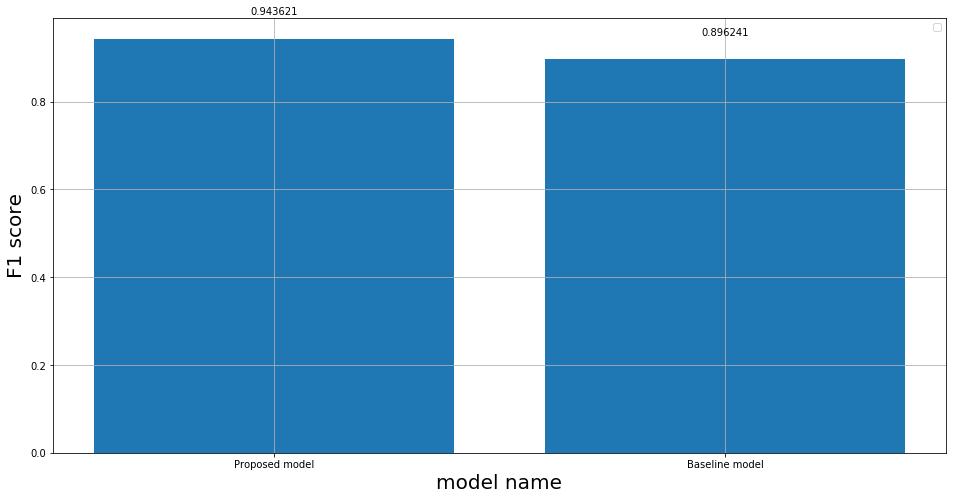

In [126]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(16, 8))
y=[cofig['f1 score'][-1],base_f1[-1]]
x = ['Proposed model','Baseline model']

plt.bar(x, y)

for a,b in zip(x,y):

    plt.text(a, b+0.05, '%.6f' % b, ha='center', va= 'bottom',fontsize=10)

# plt.title('Validation f1 score - embedding strategy',size=20)
plt.xlabel('model name',size=20)
plt.ylabel('F1 score',size=20)
plt.legend(loc='best')
plt.grid()
plt.show()

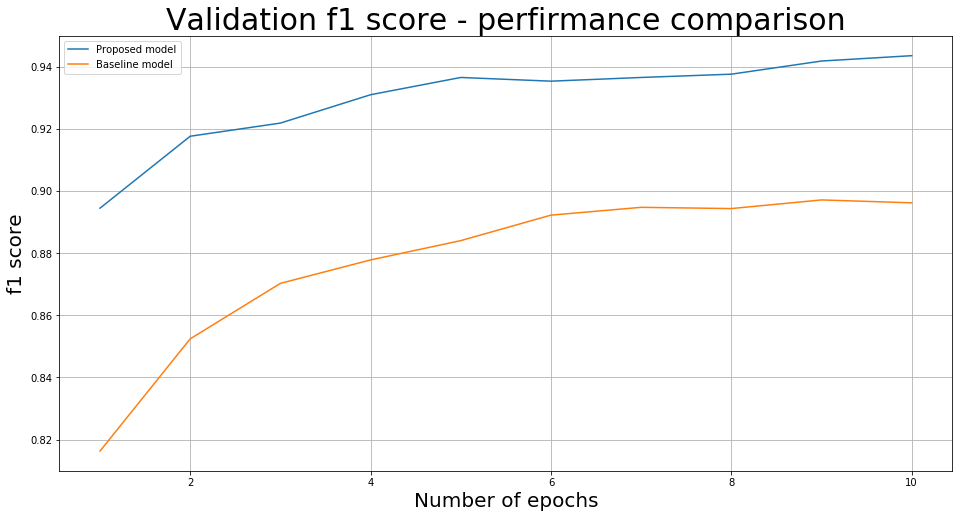

In [128]:
plt.figure(figsize=(16, 8))
x=number_of_epoches= np.arange(1,11,1)

plt.plot(x, cofig['f1 score'], label='Proposed model')
plt.plot(x, base_f1, label='Baseline model')


plt.title('Validation f1 score - perfirmance comparison',size=30)
plt.xlabel('Number of epochs',size=20)
plt.ylabel('f1 score',size=20)
plt.legend(loc='best')
plt.grid()
plt.savefig('Performance_Comparison.jpeg')
plt.show()



### 3.4.2 Model Level

No handles with labels found to put in legend.


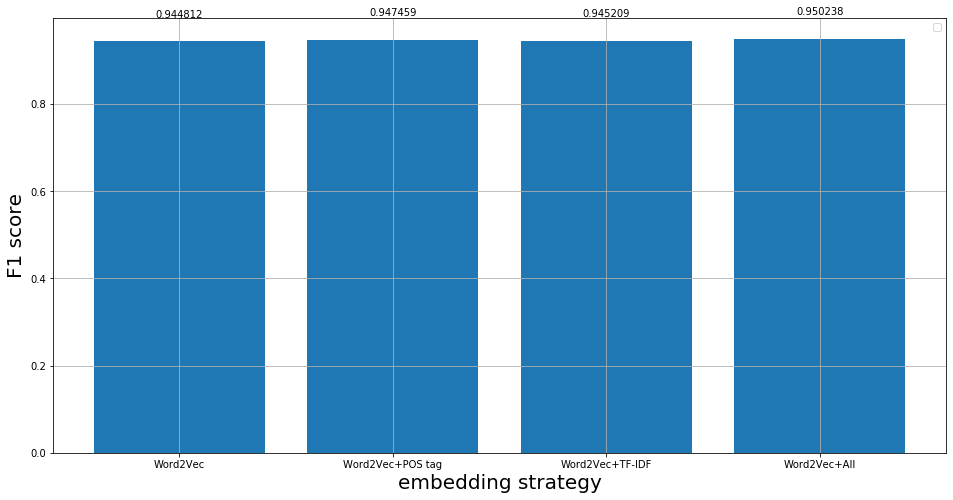

In [66]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(16, 8))
y=[]
for con in model_configs:
    y.append(con['f1 score'][-1])
x = ['Word2Vec','Word2Vec+POS tag','Word2Vec+TF-IDF','Word2Vec+All']

plt.bar(x, y)

for a,b in zip(x,y):

    plt.text(a, b+0.05, '%.6f' % b, ha='center', va= 'bottom',fontsize=10)

# plt.title('Validation f1 score - embedding strategy',size=20)
plt.xlabel('embedding strategy',size=20)
plt.ylabel('F1 score',size=20)
plt.legend(loc='best')
plt.grid()
plt.show()

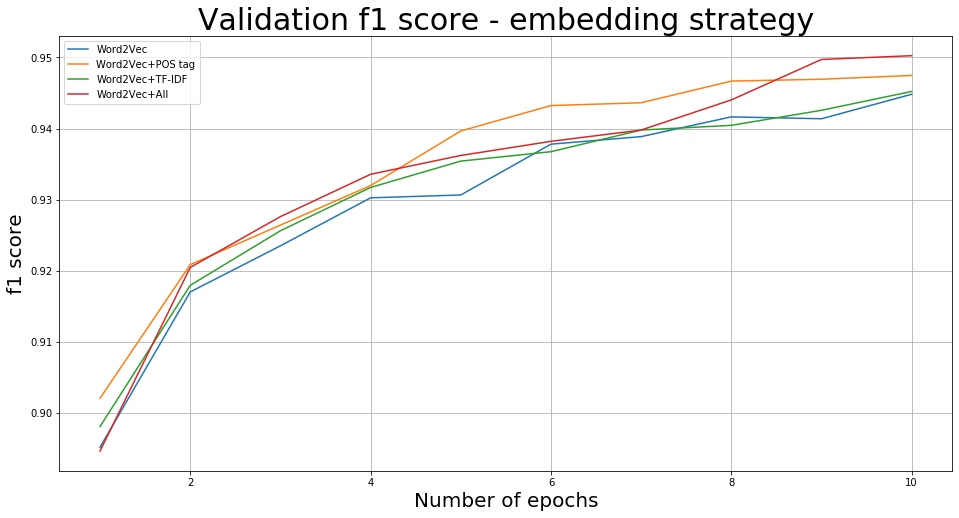

In [59]:
plt.figure(figsize=(16, 8))
x=number_of_epoches= np.arange(1,11,1)

plt.plot(x, model_configs[0]['f1 score'], label='Word2Vec')
plt.plot(x, model_configs[1]['f1 score'], label='Word2Vec+POS tag')
plt.plot(x, model_configs[2]['f1 score'], label='Word2Vec+TF-IDF')
plt.plot(x, model_configs[3]['f1 score'], label='Word2Vec+All')

plt.title('Validation f1 score - embedding strategy',size=30)
plt.xlabel('Number of epochs',size=20)
plt.ylabel('f1 score',size=20)
plt.legend(loc='best')
plt.grid()
plt.savefig('model_level.jpeg')
plt.show()


### 3.4.3 Attention Level

#### 3.4.3.1 Attention Calculate Methoc

No handles with labels found to put in legend.


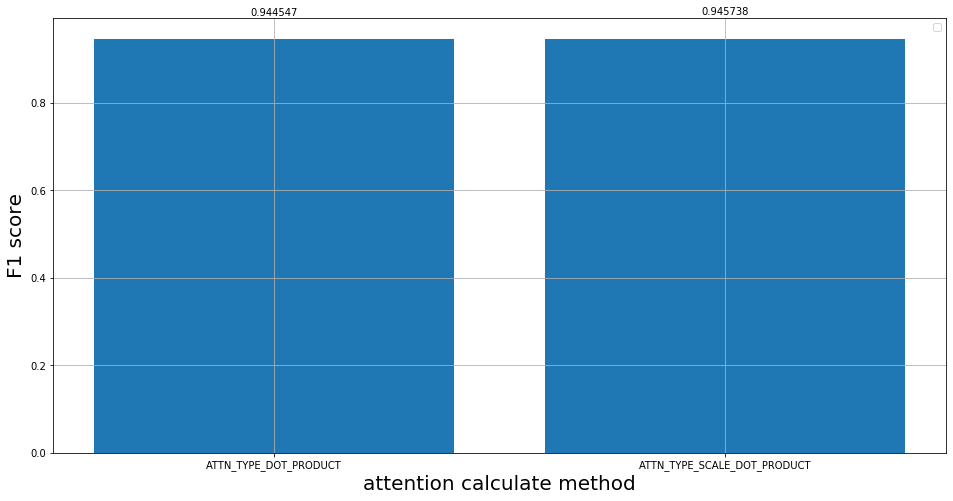

In [67]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(16, 8))
y=[]
for con in attention_configs:
    y.append(con['f1 score'][-1])
x = ['ATTN_TYPE_DOT_PRODUCT','ATTN_TYPE_SCALE_DOT_PRODUCT']

plt.bar(x, y)

for a,b in zip(x,y):

    plt.text(a, b+0.05, '%.6f' % b, ha='center', va= 'bottom',fontsize=10)

plt.xlabel('attention calculate method',size=20)
plt.ylabel('F1 score',size=20)
plt.legend(loc='best')
plt.grid()
plt.show()

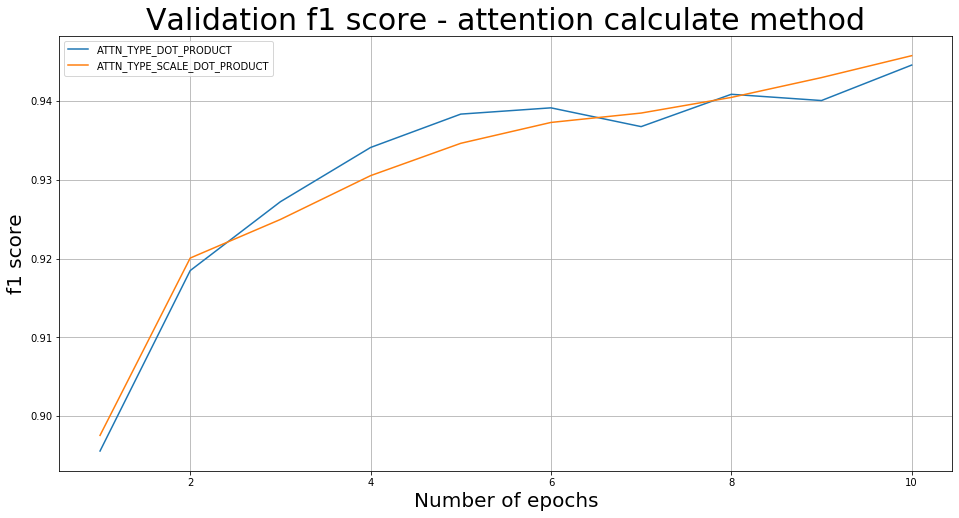

In [93]:
plt.figure(figsize=(16, 8))
x=number_of_epoches= np.arange(1,11,1)

plt.plot(x, attention_configs[0]['f1 score'], label='ATTN_TYPE_DOT_PRODUCT')
plt.plot(x, attention_configs[1]['f1 score'], label='ATTN_TYPE_SCALE_DOT_PRODUCT')

plt.title('Validation f1 score - attention calculate method',size=30)
plt.xlabel('Number of epochs',size=20)
plt.ylabel('f1 score',size=20)
plt.legend(loc='best')
plt.grid()
plt.savefig('attention_method.jpeg')
plt.show()

#### 3.4.3.2 Attention Position

No handles with labels found to put in legend.


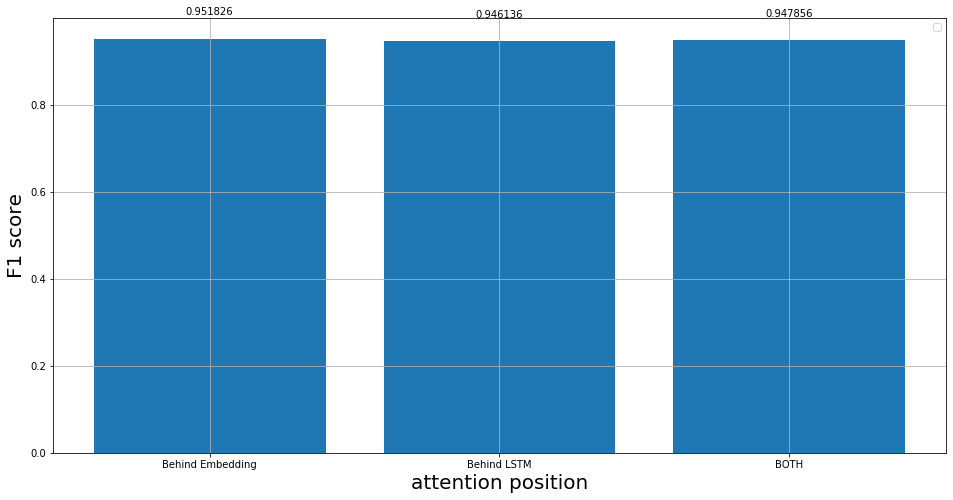

In [112]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(16, 8))
y=[]
for con in attention_position_configs:
    y.append(con['f1 score'][-1])
x = ['Behind Embedding','Behind LSTM','BOTH']

plt.bar(x, y)

for a,b in zip(x,y):

    plt.text(a, b+0.05, '%.6f' % b, ha='center', va= 'bottom',fontsize=10)

plt.xlabel('attention position',size=20)
plt.ylabel('F1 score',size=20)
plt.legend(loc='best')
plt.grid()
plt.show()

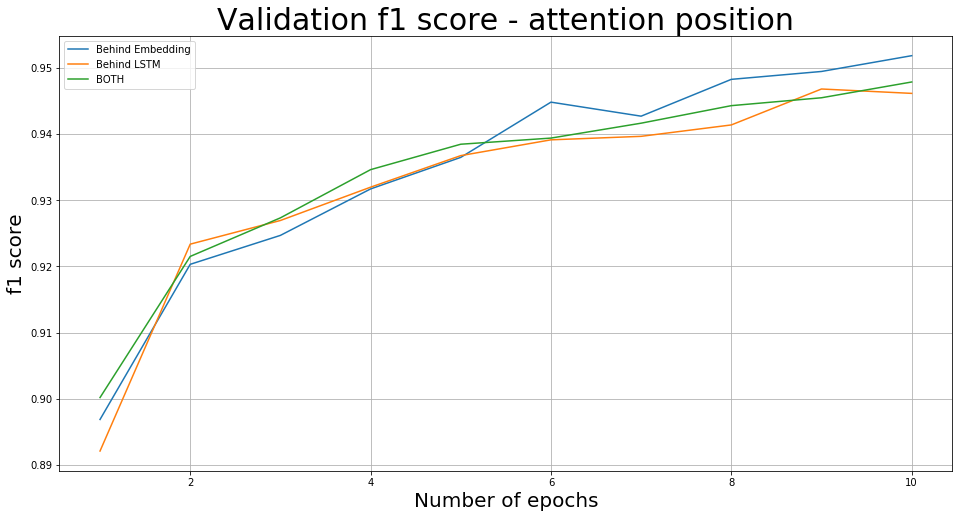

In [111]:
plt.figure(figsize=(16, 8))
x=number_of_epoches= np.arange(1,11,1)

plt.plot(x, attention_position_configs[0]['f1 score'], label='Behind Embedding')
plt.plot(x, attention_position_configs[1]['f1 score'], label='Behind LSTM')
plt.plot(x, attention_position_configs[2]['f1 score'], label='BOTH')

plt.title('Validation f1 score - attention position',size=30)
plt.xlabel('Number of epochs',size=20)
plt.ylabel('f1 score',size=20)
plt.legend(loc='best')
plt.grid()
plt.savefig('attention_position.jpeg')
plt.show()

In [113]:
for con in attention_position_configs:
    print(con['f1 score'])

[0.8969031233456856, 0.9203282159872949, 0.9246956061408153, 0.9317098994176815, 0.9364743250397035, 0.9448120698782425, 0.9426945473795659, 0.9482530439385919, 0.9494441503440975, 0.9518263631551085]
[0.8921386977236633, 0.9233721545791423, 0.9269454737956591, 0.9319745897300159, 0.9367390153520381, 0.9391212281630492, 0.9396506087877183, 0.941371095817893, 0.9467972472207518, 0.9461355214399153]
[0.9002117522498676, 0.9215193223928004, 0.927342509264161, 0.9346214928533616, 0.9384595023822128, 0.9393859184753838, 0.9416357861302276, 0.9442826892535733, 0.9454737956590789, 0.94785600847009]


### 3.4.4 Layer Level

No handles with labels found to put in legend.


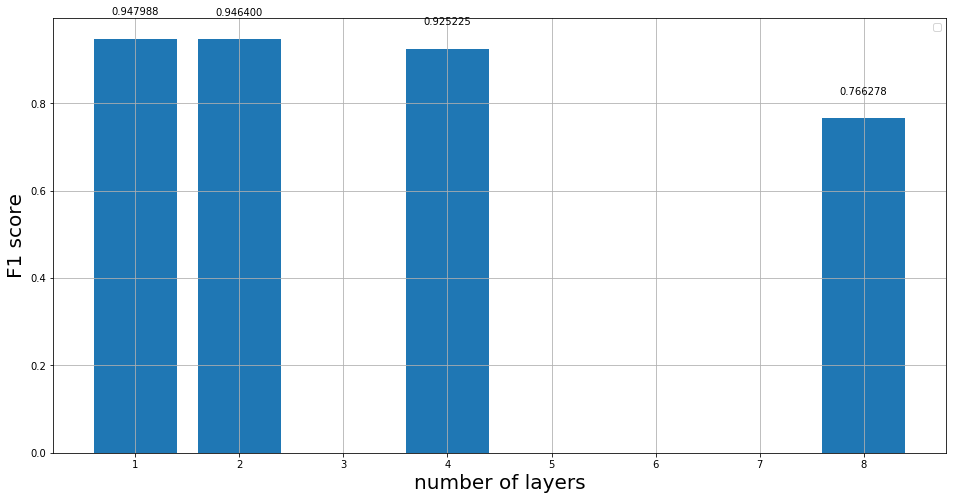

In [71]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(16, 8))
y=[]
for con in model_structure_configs:
    y.append(con['f1 score'][-1])
x = [1,2,4,8]

plt.bar(x, y)

for a,b in zip(x,y):

    plt.text(a, b+0.05, '%.6f' % b, ha='center', va= 'bottom',fontsize=10)

plt.xlabel('number of layers',size=20)
plt.ylabel('F1 score',size=20)
plt.legend(loc='best')
plt.grid()
plt.show()

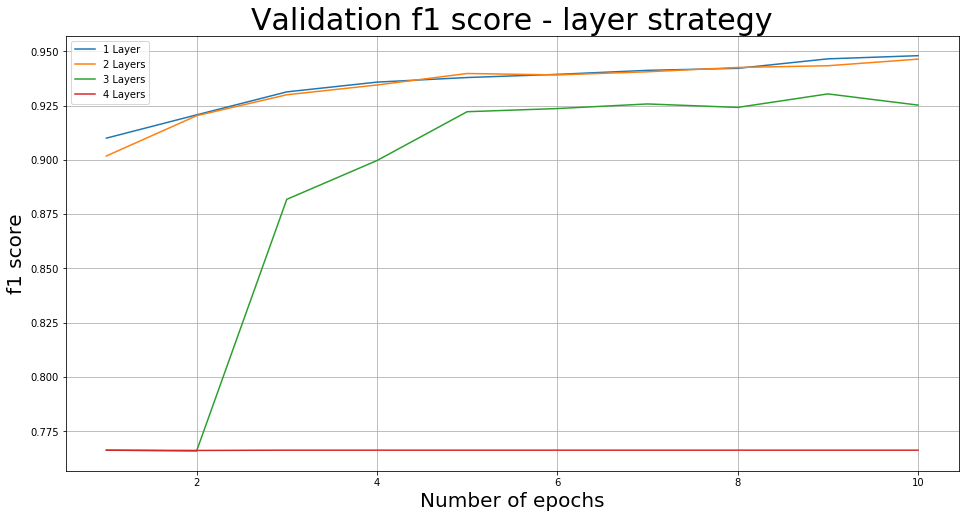

In [73]:
plt.figure(figsize=(16, 8))
x=number_of_epoches= np.arange(1,11,1)

plt.plot(x, model_structure_configs[0]['f1 score'], label='1 Layer')
plt.plot(x, model_structure_configs[1]['f1 score'], label='2 Layers')
plt.plot(x, model_structure_configs[2]['f1 score'], label='3 Layers')
plt.plot(x, model_structure_configs[3]['f1 score'], label='4 Layers')

plt.title('Validation f1 score - layer strategy',size=30)
plt.xlabel('Number of epochs',size=20)
plt.ylabel('f1 score',size=20)
plt.legend(loc='best')
plt.grid()
plt.savefig('layer.jpeg')
plt.show()